In [1]:
from preprocessing.tissue_detection import threshold_based
import openslide
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import numpy as np
import random
import pandas as pd
from preprocessing.tile_generation.utils import prep_utils as slide_utils
%matplotlib inline

In [2]:
data_dir = "/home/jiayun/Documents/deepstorage/PANDA_challenge/"
slides_dir = f"{data_dir}/train_images/"
masks_dir = f"{data_dir}/train_label_masks/"
train_slides_df = pd.read_csv(f"{data_dir}/train.csv", index_col='image_id')

### Test tissue detection

In [3]:
def plot_slides(samples, slides_dir, n_row=2):
    assert len(samples) % n_row == 0, "Please change n_row or n_samples"
    tot = 2 * len(samples)
    n_col = tot // n_row
    f, ax = plt.subplots(n_row, n_col, figsize=(18,9))
    counter = 0
    for info in samples.itertuples(index=True):
        slide_id = info.Index
        provider = info.data_provider
        group = info.isup_grade
        dw_sample = slide_utils.read_downsample_slide(slides_dir, f"{slide_id}.tiff")
        slide = openslide.OpenSlide(f"{slides_dir}/{slide_id}.tiff")
        mask = threshold_based.get_tissue_area(slide)
        
        ax[counter//n_col, counter%n_col].imshow(dw_sample)
        ax[counter//n_col, counter%n_col].set_title(f"name: {slide_id}\nprovider: {provider}\ngroup: {group}")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(dw_sample)
        ax[counter//n_col, counter%n_col].imshow(mask, alpha=0.6)
        ax[counter//n_col, counter%n_col].axis('off')
        counter += 1
    plt.show() 


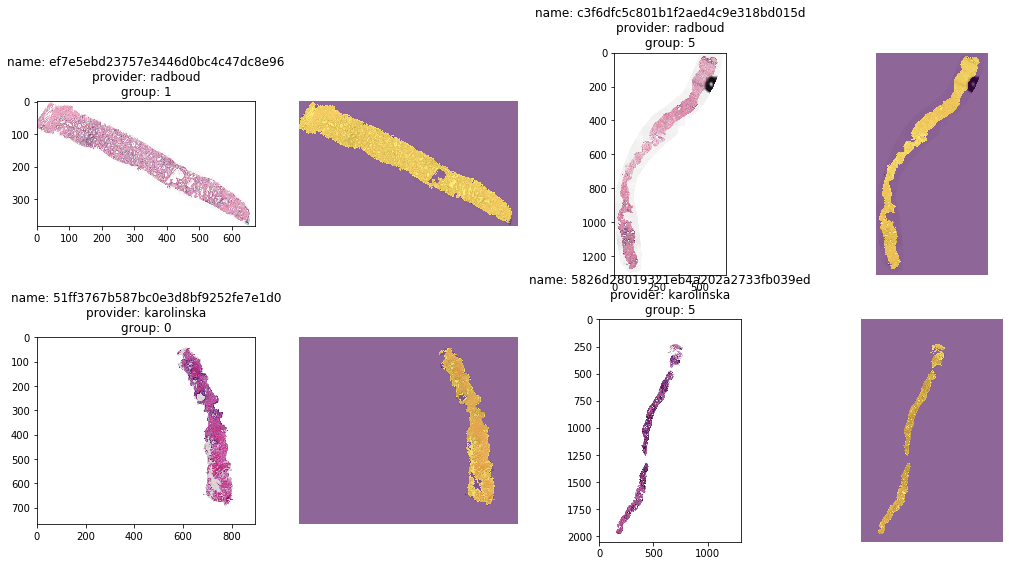

In [4]:
samples = train_slides_df.sample(4)
samples
plot_slides(samples, slides_dir, n_row=2)

### Test tile generation

In [4]:
def display_mask(mask_data, provider):
    mask_data = Image.fromarray(mask_data.astype(np.uint8))
    preview_palette = np.zeros(shape=768, dtype=int)
    if provider == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 
                                           0.5, 0.5, 0.5, 
                                           0, 1, 0, 
                                           1, 1, 0.7, # yellow
                                           1, 0.5, 0, # orange
                                           1, 0, 0]) * 255).astype(int)
    elif provider == 'karolinska':
        # provider: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 
                                          0, 1, 0, 
                                          1, 0, 0]) * 255).astype(int)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_data = mask_data.convert(mode='RGB')
    
    return mask_data

In [5]:
def plot_tiles(orig_tiles, norm_tiles, tissue_masks, label_masks, slide_id, provider, n_row=3):
    assert len(orig_tiles) % n_row == 0, "Please change n_row or n_samples"
    tot = 3 * len(orig_tiles)
    n_col = tot // n_row
    f, ax = plt.subplots(n_row, n_col, figsize=(27,9))
    counter = 0
    for orig_tile, norm_tile, mask, label in zip(orig_tiles, norm_tiles, tissue_masks, label_masks):
        converted_mask = display_mask(label, provider)
        ax[counter//n_col, counter%n_col].imshow(norm_tile)
        ax[counter//n_col, counter%n_col].axis('off')
        ax[counter//n_col, counter%n_col].set_title(f"Norm name: {slide_id}\nprovider: {provider}")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(orig_tile)
        ax[counter//n_col, counter%n_col].axis('off')
        ax[counter//n_col, counter%n_col].set_title("Orig")
        counter += 1
        
        ax[counter//n_col, counter%n_col].imshow(orig_tile)
        ax[counter//n_col, counter%n_col].imshow(converted_mask, alpha=0.6)
        ax[counter//n_col, counter%n_col].axis('off')
        counter += 1
        
    plt.show() 

In [34]:
from preprocessing.tile_generation import generate_grid
from preprocessing.normalization import reinhard_bg
tile_normalizer = reinhard_bg.ReinhardNormalizer()

In [38]:
sample = train_slides_df.sample(1)
sample

,data_provider,isup_grade,gleason_score
image_id,,,
9d8ab96e43f381bff9816daee10b7100,karolinska,4,4+4


In [39]:
tile_generator = generate_grid.TileGeneratorGrid(slides_dir, f"{sample.index[0]}.tiff", masks_dir, verbose=True)
orig_tiles, norm_tiles, locations, tissue_masks, label_masks \
            = tile_generator.extract_all_tiles(512, 0.25, 0.5, 1, tile_normalizer)

Generate 248 tiles in the grid
Time to generate 248 tiles from 9d8ab96e43f381bff9816daee10b7100 slide: 27.61


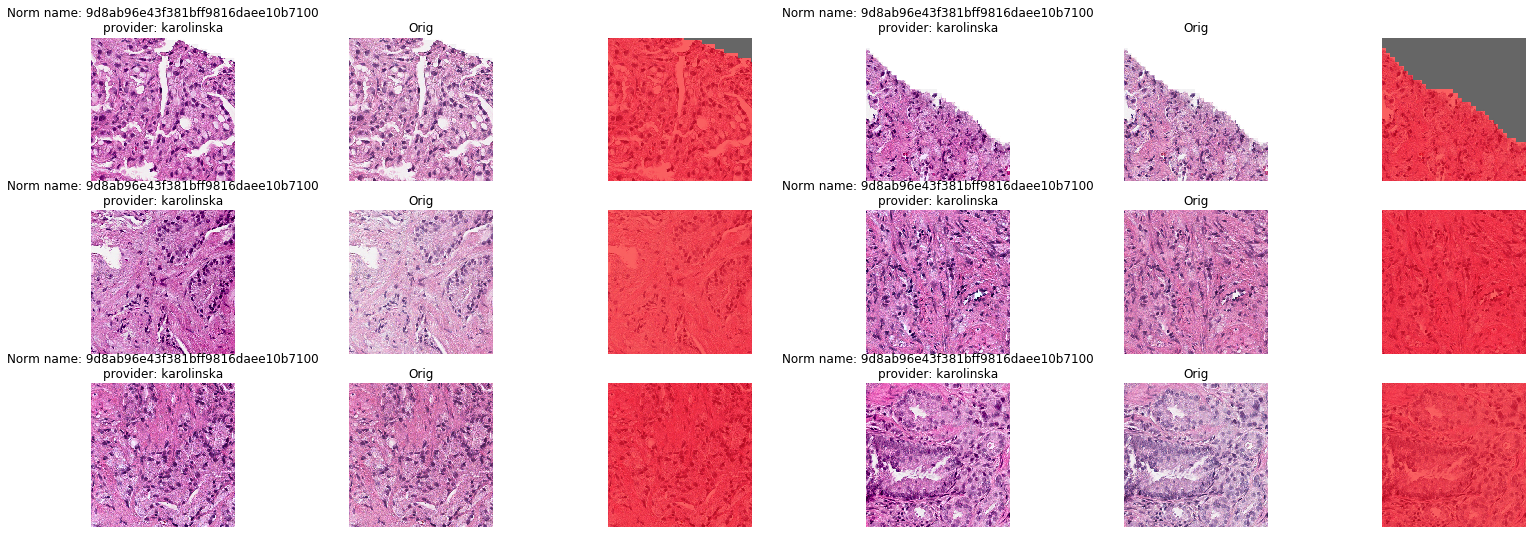

In [40]:
sample_tile_idx = random.sample(range(0, len(orig_tiles)), 6)
sample_orig, sample_norm = orig_tiles[sample_tile_idx], norm_tiles[sample_tile_idx]
sample_mask, sample_label = tissue_masks[sample_tile_idx], label_masks[sample_tile_idx]
plot_tiles(sample_orig, sample_norm, sample_mask, sample_label, sample.index[0], sample.data_provider[0])

In [15]:
locations[0]

array([21888,  9216])

### Test extracted tiles and masks

In [6]:
import lmdb
import json
import matplotlib.patches as patches

In [7]:
lmdb_dir = f"{data_dir}/sample_processed/"
env_tiles = lmdb.open(f"{lmdb_dir}/tiles", max_readers=3, readonly=True, lock=False,
                    readahead=False, meminit=False)
env_label_masks = lmdb.open(f"{lmdb_dir}/label_masks", max_readers=3, readonly=True, lock=False,
                readahead=False, meminit=False)
env_tissue_masks = lmdb.open(f"{lmdb_dir}/tissue_masks", max_readers=3, readonly=True, lock=False,
                readahead=False, meminit=False)
env_locations = lmdb.open(f"{lmdb_dir}/locations", max_readers=3, readonly=True, lock=False,
                readahead=False, meminit=False)
slide_tiles_map = json.load(open(f"{lmdb_dir}/slides_tiles_mappding.json", "r"))

In [22]:
def read_lmdb(slide_id, slide_tiles_map, env_tiles, env_labels, env_masks, env_locs, tile_size=512):
    tile_names = slide_tiles_map[slide_id]
    tiles = np.zeros((len(tile_names), tile_size, tile_size, 3), dtype=np.uint8)
    labels = np.zeros((len(tile_names), tile_size, tile_size), dtype=np.uint8)
    masks = np.zeros((len(tile_names), tile_size, tile_size), dtype=np.uint8)
    counter = 0
    
    with env_tiles.begin(write=False) as txn_tiles, env_labels.begin(write=False) as txn_labels, \
            env_masks.begin(write=False) as txn_masks, env_locs.begin(write=False) as txn_loc:
        for tile_name in tile_names:
            tilebuf = txn_tiles.get(str(tile_name).encode())
            tilebuf = np.frombuffer(tilebuf, dtype=np.uint8)
            tilebuf = tilebuf.reshape(512, 512, 3)
            
            if txn_labels.get(str(tile_name).encode()) is not None:
                labelbuf = txn_labels.get(str(tile_name).encode())
                labelbuf = np.frombuffer(labelbuf, dtype=np.uint8)
                labelbuf = labelbuf.reshape(512, 512)
            else:
                labelbuf = None
            
            maskbuf = txn_masks.get(str(tile_name).encode())
            maskbuf = np.frombuffer(maskbuf, dtype=np.uint8)
            maskbuf = maskbuf.reshape(512, 512)
            
            tiles[counter, :, :, :] = tilebuf
            if labelbuf is not None:
                # print('hi')
                labels[counter, :, :] = labelbuf
            masks[counter, :, :] = maskbuf
            counter += 1
        tile_locations = txn_loc.get(str(slide_id).encode())
        tile_locations = np.frombuffer(tile_locations, dtype=np.int64)
        tile_locations = tile_locations.reshape(-1, 2)
    return tiles, masks, labels, tile_locations
         

In [47]:
def visualize_selected(cur_tile_locs, slide_id, slides_dir, tile_size=512):
    slide = openslide.OpenSlide(f"{slides_dir}/{slide_id}.tiff")
    level = slide.level_count
    level -= 1
    dw_samples_dim = slide.level_dimensions[level]
    # get sample from lowest available resolution
    dw_im = slide.read_region((0, 0), level, (dw_samples_dim[0], dw_samples_dim[1]))
    loc_dw_rate = int(slide.level_downsamples[level])
    
    dpi = 100
    fig_height = float(dw_im.size[0]) / float(dpi)
    fig_width = float(dw_im.size[1]) / float(dpi)
    fig, ax = plt.subplots(1, figsize=(fig_width, fig_height))
    ax.imshow(dw_im)
    tile_size = int(float(tile_size) / float(loc_dw_rate))

    for idx, loc in enumerate(cur_tile_locs):
        x = int(float(loc[1]) / float(loc_dw_rate))
        y = int(float(loc[0]) / float(loc_dw_rate))
        rect = patches.Rectangle((y, x), tile_size, tile_size, linewidth=3, edgecolor='black',
                                     facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    

In [42]:
# sample_slide_name = random.sample(list(slide_tiles_map.keys()), 2)[0]
sample_slide_name = random.sample(list(slide_tiles_map.keys()), 1)[0]
sample = train_slides_df.loc[sample_slide_name]
sample

data_provider    radboud
isup_grade             4
gleason_score        4+4
Name: 0018ae58b01bdadc8e347995b69f99aa, dtype: object

In [43]:
tiles, masks, labels, tile_locations = read_lmdb(sample_slide_name, slide_tiles_map, env_tiles, env_label_masks, 
                                                 env_tissue_masks, env_locations, tile_size=512)


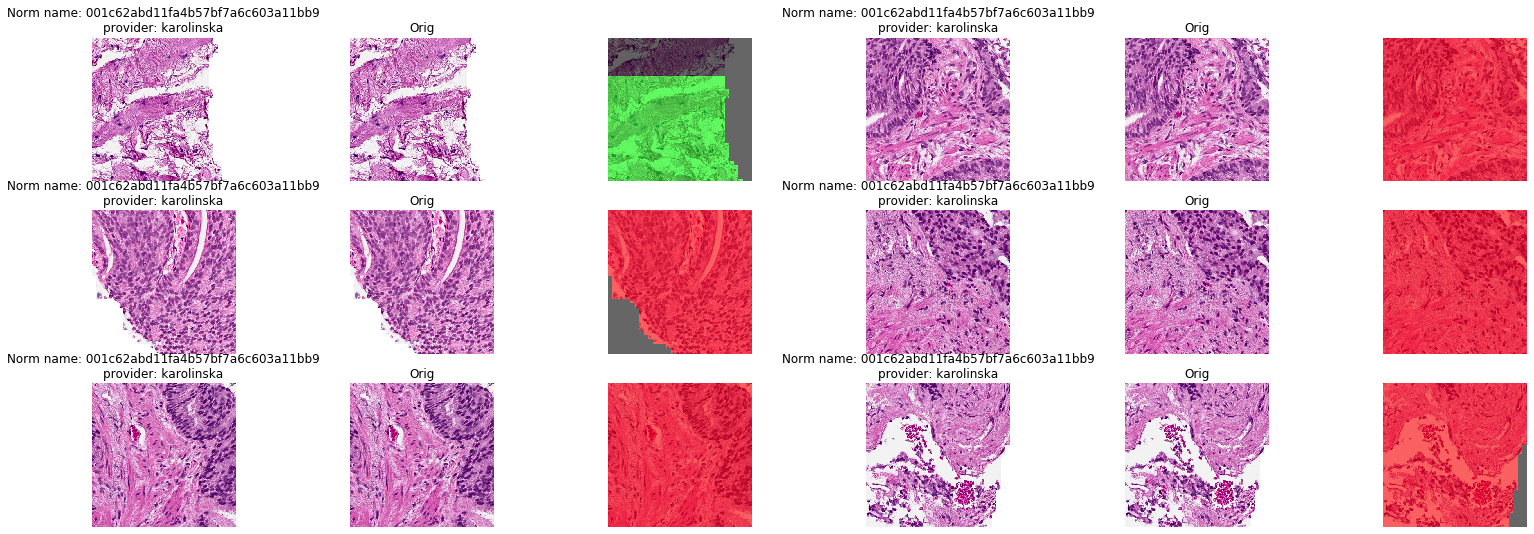

In [32]:
sample_tile_idx = random.sample(range(0, len(tiles)), 6)
sample_orig, sample_norm = tiles[sample_tile_idx], tiles[sample_tile_idx]
sample_mask, sample_label = masks[sample_tile_idx], labels[sample_tile_idx]
plot_tiles(sample_orig, sample_norm, sample_mask, sample_label, sample_slide_name, sample.data_provider)

Generate 223 tiles in the grid
Time to generate 223 tiles from 001c62abd11fa4b57bf7a6c603a11bb9 slide: 22.44


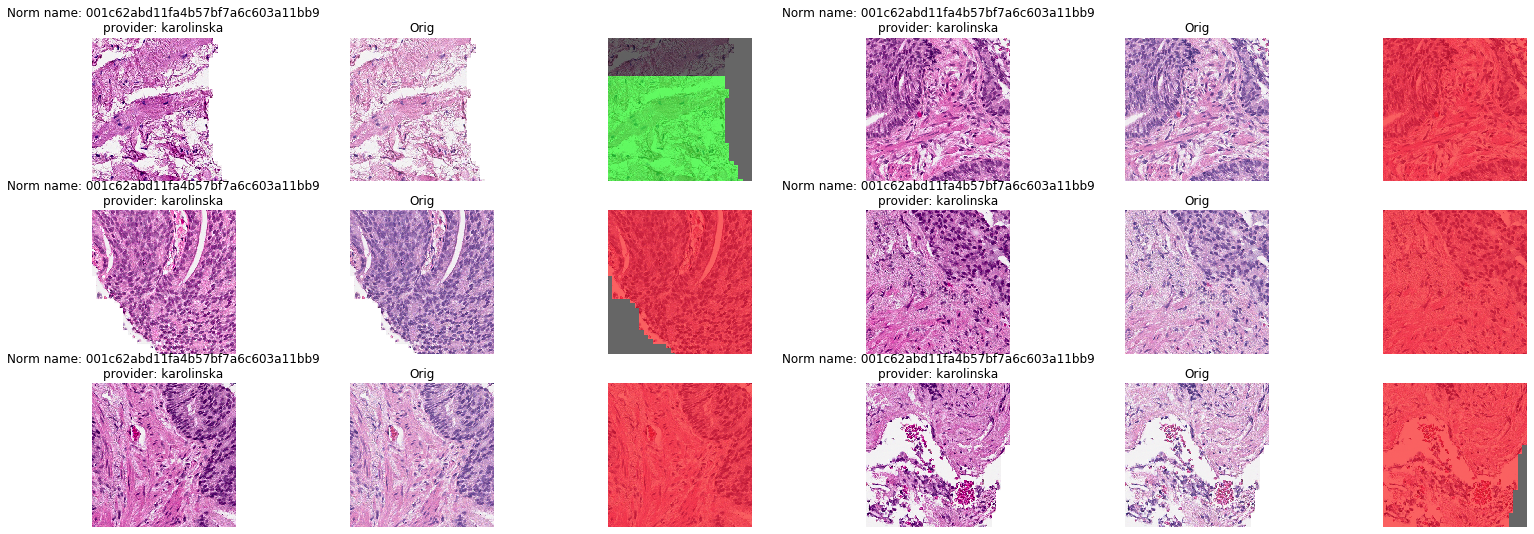

In [37]:
tile_generator = generate_grid.TileGeneratorGrid(slides_dir, f"{sample_slide_name}.tiff", masks_dir, verbose=True)
orig_tiles, norm_tiles, locations, tissue_masks, label_masks \
            = tile_generator.extract_all_tiles(512, 0.25, 0.5, 1, tile_normalizer)
sample_orig, sample_norm = orig_tiles[sample_tile_idx], norm_tiles[sample_tile_idx]
sample_mask, sample_label = tissue_masks[sample_tile_idx], label_masks[sample_tile_idx]
plot_tiles(sample_orig, sample_norm, sample_mask, sample_label, sample_slide_name, sample.data_provider)

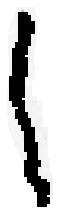

In [48]:
visualize_selected(tile_locations, sample_slide_name, slides_dir, tile_size=512)